In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,recall_score
%matplotlib inline
# from catboost import CatBoostClassifier, FeaturesData
import datetime as DT
import io
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN 
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 4
import seaborn as sns
sns.set()
# first neural network with keras tutorial
from keras.models import Sequential
from keras.layers import Dense
from datetime import *
from dateutil.relativedelta import *

Using TensorFlow backend.


Importando arquivos

In [3]:
tabelao = pd.read_csv('TABELAO_FINAL.csv')

In [5]:
tabelao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102419 entries, 0 to 102418
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CODIGO_CLIENTE           102419 non-null  int64  
 1   DATA_NASCIMENTO          102415 non-null  object 
 2   IDADE                    102419 non-null  int64  
 3   SEXO                     102418 non-null  object 
 4   ESTADO_CIVIL             102418 non-null  object 
 5   CIDADE                   102419 non-null  object 
 6   UF                       102419 non-null  object 
 7   BAIRRO                   102419 non-null  object 
 8   CEP                      102419 non-null  float64
 9   QTD_DEPENDENTES          102417 non-null  float64
 10  DATA_CADASTRO            102419 non-null  object 
 11  DATA_ADMISSAO            55297 non-null   object 
 12  CATEGORIAL_PROFISSAO     100611 non-null  object 
 13  TIPO_RESIDENCIA          101416 non-null  object 
 14  REND

In [6]:
# tabelao.DATA_NASCIMENTO = pd.to_datetime(tabelao.DATA_NASCIMENTO)
# idade = tabelao['DATA_NASCIMENTO'].apply(lambda x: (datetime.now().year - x.year))
# tabelao.insert(loc=2, column='IDADE', value=idade.fillna(0).astype(int))
# tabelao.to_csv('TABELAO_FINAL.csv',index=False)

In [7]:
tabelao['VALOR_HISTORICO_COMPRAS'].describe()

count    102419.000000
mean       2450.453929
std        3031.341107
min           0.000000
25%         719.760000
50%        1638.170000
75%        3190.325000
max      136495.490000
Name: VALOR_HISTORICO_COMPRAS, dtype: float64

In [8]:
tabelao['DATA_CADASTRO'] = pd.to_datetime(tabelao['DATA_CADASTRO'])
tabelao['MES'] = tabelao['DATA_CADASTRO'].apply(lambda x: x.month)
gb = tabelao.groupby(['MES', 'CLASS']).size()

In [9]:
fontsize = 16
linewidth = 2

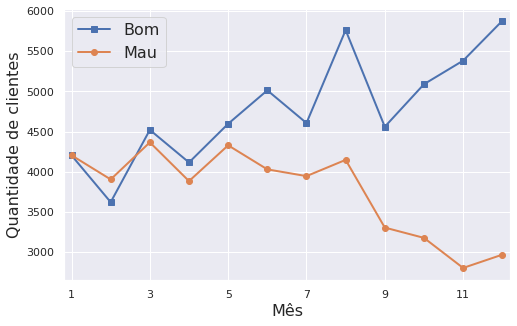

In [10]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,13), gb.values[0::2], label= 'Bom', marker= 's', linewidth= linewidth)
plt.plot(np.arange(1,13), gb.values[1::2], label= 'Mau', marker= 'o', linewidth= linewidth)
plt.xlabel('Mês', fontsize= fontsize)
plt.xticks(np.arange(1,13, 2))
plt.ylabel('Quantidade de clientes', fontsize= fontsize)
plt.xlim([0.8,12.2])
plt.legend(fontsize= fontsize)
plt.savefig('./results/quantidades.png', bbox_inches = 'tight',
        pad_inches = 0)

In [11]:
# tabelao = tabelao.drop(columns=['SEXO', 'CODIGO_CLIENTE','DATA_NASCIMENTO','CIDADE','UF', 'BAIRRO','CEP','DATA_ADMISSAO',
#              'RENDA_CJ','OUTRAS_RENDAS','FLAG_CONTA_BANCO',
#                                 'VALOR_HISTORICO_COMPRAS', 'DATA_LIMITE'], axis=1)

In [12]:
tabelao = tabelao[['MES', 'IDADE', 'VALOR_HISTORICO_COMPRAS', 'TIPO_RESIDENCIA', 'QTD_DEPENDENTES', 'ESTADO_CIVIL', 'CATEGORIAL_PROFISSAO', 'DATA_CADASTRO', 'CLASS']]

In [13]:
tabelao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102419 entries, 0 to 102418
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   MES                      102419 non-null  int64         
 1   IDADE                    102419 non-null  int64         
 2   VALOR_HISTORICO_COMPRAS  102419 non-null  float64       
 3   TIPO_RESIDENCIA          101416 non-null  object        
 4   QTD_DEPENDENTES          102417 non-null  float64       
 5   ESTADO_CIVIL             102418 non-null  object        
 6   CATEGORIAL_PROFISSAO     100611 non-null  object        
 7   DATA_CADASTRO            102419 non-null  datetime64[ns]
 8   CLASS                    102419 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 7.0+ MB


In [14]:
tabelao = tabelao.dropna()

In [15]:
tabelao.head()

,MES,IDADE,VALOR_HISTORICO_COMPRAS,TIPO_RESIDENCIA,QTD_DEPENDENTES,ESTADO_CIVIL,CATEGORIAL_PROFISSAO,DATA_CADASTRO,CLASS
0,10,46,1225.73,PR,0.0,SO,AUT+NOMO,2017-10-31,0
1,11,42,1045.04,AL,0.0,SO,APOSENTADO,2017-11-30,1
2,3,64,3280.56,PR,0.0,SO,APOSENTADO,2017-03-13,0
3,11,59,1337.71,PR,0.0,SE,ASSALARIADO,2017-11-14,0
4,2,52,5987.88,PR,0.0,CA,ASSALARIADO,2017-02-20,1


In [17]:
len(tabelao)

99627

## TABELA DE MODELAGEM

In [51]:
def compare_RESIDENCIA(residencia):
    if residencia == 'PR':
        return 1
    else:
        return 0

In [52]:
tabelao['TIPO_RESIDENCIA'] = list(map(compare_RESIDENCIA, tabelao['TIPO_RESIDENCIA']))

In [53]:
def compare_PROFISSAO(profissao):
    if profissao == 'APOSENTADO':
        return 'APOSENTADO'
    elif profissao == 'AUT+NOMO':
        return 'AUTONOMO'
    else:
        return 'OU'

In [54]:
tabelao['CATEGORIAL_PROFISSAO'] = list(map(compare_PROFISSAO, tabelao['CATEGORIAL_PROFISSAO']))

In [55]:
def compare_CIVIL(civil):
    if civil == 'SO':
        return 'SO'
    elif civil == 'CA':
        return 'CA'
    else:
        return 'OU'

In [56]:
tabelao['ESTADO_CIVIL'] = list(map(compare_CIVIL, tabelao['ESTADO_CIVIL']))

In [57]:
def compare_IDADE(idade):
    if idade <= 25:
        return 0
    elif (idade > 25) & (idade <= 35):
        return 1
    elif (idade > 35) & (idade <= 45):
        return 2
    elif (idade > 45) & (idade <= 55):
        return 3
    elif (idade > 55) & (idade <= 65):
        return 4
    else:
        return 5

In [58]:
tabelao['IDADE'] = list(map(compare_IDADE, tabelao['IDADE']))

In [262]:
def compare_RENDA(renda):
    if renda <= 1000:
        return 0
    elif (renda > 1000) & (renda <= 1500):
        return 1
    elif (renda > 1500) & (renda <= 2000):
        return 2
    elif (renda > 2000) & (renda <= 2500):
        return 3
    else:
        return 4

In [ ]:
tabelao['RENDA_TITULAR'] = list(map(compare_RENDA, tabelao['RENDA_TITULAR']))

In [59]:
def compare_DEPENDENTES(qtd):
    if qtd <= 0:
        return 0
    else:
        return 1

In [60]:
tabelao['QTD_DEPENDENTES'] = list(map(compare_DEPENDENTES, tabelao['QTD_DEPENDENTES']))

In [333]:
def compare_SEXO(sexo):
    if sexo == 'M':
        return 0
    else:
        return 1

In [ ]:
tabelao['SEXO'] = list(map(compare_SEXO, tabelao['SEXO']))

In [61]:
tabelao.head()

,MES,IDADE,VALOR_HISTORICO_COMPRAS,TIPO_RESIDENCIA,QTD_DEPENDENTES,ESTADO_CIVIL,CATEGORIAL_PROFISSAO,DATA_CADASTRO,CLASS
0,10,3,1225.73,1,0,SO,AUTONOMO,2017-10-31,0
1,11,2,1045.04,0,0,SO,APOSENTADO,2017-11-30,1
2,3,4,3280.56,1,0,SO,APOSENTADO,2017-03-13,0
3,11,4,1337.71,1,0,OU,OU,2017-11-14,0
4,2,3,5987.88,1,0,CA,OU,2017-02-20,1


In [62]:
# df_1 = tabelao[tabelao.CLASS==1].iloc[:10000,:]
# df_0 = tabelao[tabelao.CLASS==0].iloc[:10000,:]

In [63]:
# df_model = df_1.append(df_0)

In [64]:
# df_2 = tabelao[tabelao.CLASS==1].iloc[10000:,:]
# df_3 = tabelao[tabelao.CLASS==0].iloc[10000:,:]

In [65]:
# df_score = df_2.append(df_3)

In [66]:
tabelao = pd.get_dummies(tabelao, columns=['ESTADO_CIVIL', 'CATEGORIAL_PROFISSAO'], drop_first=True)

In [67]:
tabelao.head()

,MES,IDADE,VALOR_HISTORICO_COMPRAS,TIPO_RESIDENCIA,QTD_DEPENDENTES,DATA_CADASTRO,CLASS,ESTADO_CIVIL_OU,ESTADO_CIVIL_SO,CATEGORIAL_PROFISSAO_AUTONOMO,CATEGORIAL_PROFISSAO_OU
0,10,3,1225.73,1,0,2017-10-31,0,0,1,1,0
1,11,2,1045.04,0,0,2017-11-30,1,0,1,0,0
2,3,4,3280.56,1,0,2017-03-13,0,0,1,0,0
3,11,4,1337.71,1,0,2017-11-14,0,1,0,0,1
4,2,3,5987.88,1,0,2017-02-20,1,0,0,0,1


In [68]:
# tabelao['QTD_DEPENDENTES'] = tabelao['QTD_DEPENDENTES'].apply(lambda x: 1 if x>0 else 0)

In [69]:
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler

In [103]:
train, test = tabelao.loc[tabelao['DATA_CADASTRO'] < datetime.strptime('2017-10-01', '%Y-%m-%d')], tabelao.loc[tabelao['DATA_CADASTRO'] >= datetime.strptime('2017-10-01', '%Y-%m-%d')]

In [104]:
X, y = train.drop(labels = ['DATA_CADASTRO', 'CLASS'], axis= 1).values, train['CLASS'].values
X_test, y_test = test.drop(labels = ['DATA_CADASTRO', 'CLASS'], axis= 1), test['CLASS']

In [105]:
np.unique(y_test, return_counts= True)

(array([0, 1]), array([15988,  8671]))

In [106]:
np.unique(y, return_counts= True)

(array([0, 1]), array([40028, 34940]))

# Model Selection

In [107]:
skf = StratifiedKFold(n_splits=5, random_state=42)
metrics = np.zeros((4, 3))

for train_index, test_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    #Scaling
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_val = sc_X.transform(X_val)
    
    # Random forest
    rf = RandomForestClassifier(n_estimators= 30, max_depth= 5)
    rf.fit(X_train, y_train)
    pred0 = rf.predict(X_val)
    rf_met = [accuracy_score(y_val, pred0),
                                roc_auc_score(y_val, pred0),
                                recall_score(y_val, pred0, pos_label= 0)]
    

    #XGBoosting
    model1 = xgb.XGBClassifier()
    model1.fit(X_train, y_train)
    pred1 = model1.predict(X_val)
    # pred1 = list(map(lambda x: 1 if x[1] > 0.45 else 0, pred1))
#     print(classification_report(y_val, pred1))
    xgb_met = [accuracy_score(y_val, pred1),
                                roc_auc_score(y_val, pred1),
                                recall_score(y_val, pred1, pos_label= 0)]
    

    #Logistic Regression
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    pred2 = lr.predict(X_val)
#     print(classification_report(y_val, pred2))
    lr_met = [accuracy_score(y_val, pred2),
                                roc_auc_score(y_val, pred2),
                                recall_score(y_val, pred2, pos_label= 0)]
    

    #MLP
    mlp = MLPClassifier(solver='adam', alpha=1e-4,
                        hidden_layer_sizes=(32,16),
                        early_stopping=True)
    mlp.fit(X_train, y_train)
    pred3 = mlp.predict(X_val)
#     print(classification_report(y_val, pred3))
    mlp_met = [accuracy_score(y_val, pred3),
                                roc_auc_score(y_val, pred3),
                                recall_score(y_val, pred3, pos_label= 0)]
    
    metrics += np.array([rf_met, xgb_met, lr_met, mlp_met])
    
metrics = metrics/skf.n_splits

In [123]:
pd.DataFrame(metrics, columns=['Acurácia', 'AUC', 'Recall'], index= ['RF','XGB','Log. Reg.', 'MLP'])

,Acurácia,AUC,Recall
RF,0.631803,0.622808,0.755376
XGB,0.619438,0.613942,0.694943
Log. Reg.,0.634724,0.631173,0.683525
MLP,0.647837,0.640650,0.746555


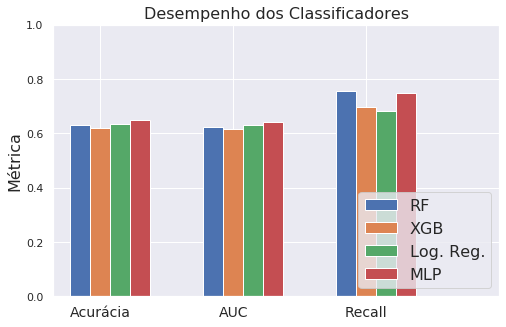

In [146]:
rcParams['figure.figsize'] = 8, 5
barWidth = 0.15
# Set position of bar on X axis
r1 = np.arange(metrics.shape[1])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, metrics[0, :], width=barWidth, edgecolor='white', label='RF')
plt.bar(r2, metrics[1, :], width=barWidth, edgecolor='white', label='XGB')
plt.bar(r3, metrics[2, :], width=barWidth, edgecolor='white', label='Log. Reg.')
plt.bar(r4, metrics[3, :], width=barWidth, edgecolor='white', label='MLP')

# Add xticks on the middle of the group bars
plt.ylim([0, 1])

plt.ylabel('Métrica', fontsize= fontsize)
plt.xticks([r + barWidth for r in range(metrics.shape[0])], ['Acurácia', 'AUC', 'Recall'], fontsize=fontsize-2)

# Create legend & Show graphic
plt.legend(loc = 'lower right', fontsize=fontsize)
plt.title('Desempenho dos Classificadores', fontsize= fontsize)
plt.savefig('./results/metrics.png', bbox_inches = 'tight',
        pad_inches = 0)

# Best model

In [147]:
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)

#MLP
mlp = MLPClassifier(solver='adam', alpha=1e-4,
                    hidden_layer_sizes=(32,16),
                    early_stopping=True)
mlp.fit(X, y)
pred3 = mlp.predict(X_test)
#     print(classification_report(y_val, pred3))
mlp_met = [accuracy_score(y_test, pred3),
                            roc_auc_score(y_test, pred3),
                            recall_score(y_test, pred3, pos_label= 0)]

In [148]:
mlp_met

[0.7268340159779391, 0.6534070090395037, 0.9008631473605204]

In [149]:
probability = mlp.predict_proba(X_test)

In [150]:
prob_range = np.arange(0,1,0.01)

In [151]:
len(prob_range)

100

In [152]:
good = np.where(y_test == 0)[0]
bad = np.where(y_test == 1)[0]

In [153]:
Mau = []
Bom = []
for i in prob_range:
    Bom.append(len(np.where(probability[list(good), 0] <= i)[0])/len(good))
    Mau.append(len(np.where(probability[list(bad), 0] <= i)[0])/len(bad))

In [154]:
from scipy import stats
stats.ks_2samp(data1= Bom, data2= Mau)

Ks_2sampResult(statistic=0.36, pvalue=3.751914289152195e-06)

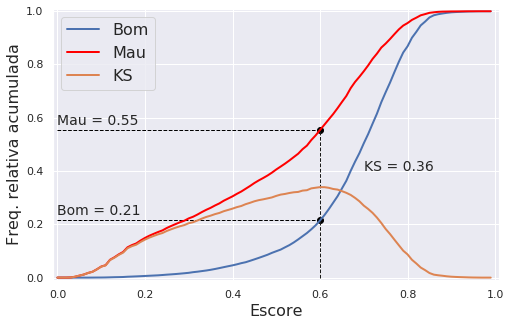

In [197]:
linwidth = 1
plt.figure(figsize= (8,5))
plt.plot(prob_range, Bom, label='Bom',  linewidth= linewidth)
plt.plot(prob_range, Mau, label= 'Mau',c='red', linewidth= linewidth)
plt.plot(prob_range, np.absolute(np.array(Bom) - np.array(Mau)), label='KS', linewidth= linewidth)
xmax= np.absolute(np.array(Bom) - np.array(Mau)).argmax()
plt.hlines(y= Mau[xmax], xmin= 0, xmax= 0.6, color= 'black', linestyle='--', linewidth= linwidth)
plt.hlines(y= Bom[xmax], xmin= 0, xmax= 0.6, color= 'black', linestyle='--', linewidth= linwidth)
plt.vlines(x= prob_range[xmax], ymin= 0, ymax= Mau[xmax], linestyle='--', linewidth= linwidth)
plt.xlabel('Escore', fontsize= fontsize)
plt.ylabel('Freq. relativa acumulada',fontsize= fontsize)
plt.text(x=0.7, y=0.4, s='KS = {}'.format(str(stats.ks_2samp(data1= Bom, data2= Mau)[0])), fontsize= fontsize-2)
plt.text(x=0., y= 0.02+Mau[xmax], s= 'Mau = {}'.format(str(round(Mau[xmax], 2))),fontsize= fontsize-2)
plt.text(x=0., y= 0.02+Bom[xmax], s= 'Bom = {}'.format(str(round(Bom[xmax], 2))),fontsize= fontsize-2)
plt.scatter([prob_range[xmax], prob_range[xmax]], [Mau[xmax], Bom[xmax]], color= 'black')

plt.xlim([-.01,1.01])
plt.ylim([-.01,1.01])
plt.legend(fontsize= fontsize)
plt.savefig('./results/KS.png', bbox_inches = 'tight',
        pad_inches = 0)

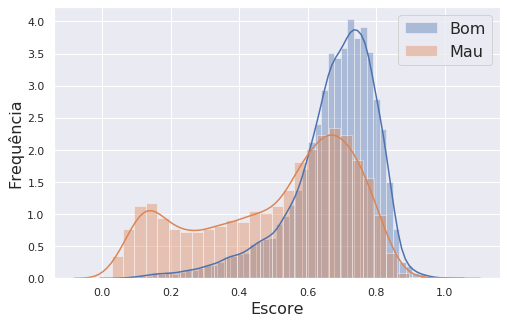

In [159]:
plt.figure(figsize= (8,5))
sns.distplot(probability[good,0], label= 'Bom')
sns.distplot(probability[bad,0], label= 'Mau')
plt.xlabel('Escore', fontsize= fontsize)
plt.ylabel('Frequência', fontsize= fontsize)
plt.legend(fontsize= fontsize)
plt.savefig('./results/dists.png', bbox_inches = 'tight',
        pad_inches = 0)